# Model Training 
 - Train-Test split 80:20
 - Baseline Model (Mean Model)
 - Linear Regression 
 - Random Forest Regressor
 - Hyper-param tuning
 - Storing Model to a file
 - Prediction on an instance

 Takeaways:
 - Models are not performing well, insignificant imporvement over mean model
 - Error plots shows that,
    - Overestimating smaller values and underestimating higher values (just like a mean model), suggestes missing factors/variables that would predict medical cost accurately. Though we have annual premium which correlates a lot, but I don't want to use it as there could be another model or human intelligence predicting it
 - Anyhow using linear regression model for final deployment


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_config_params
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor


In [41]:
# UTILS
def get_error(y_test, y_test_pred, y_train, y_train_pred):
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("Train RMSE:",train_rmse, "-- Test RMSE:", test_rmse)
    return test_rmse, train_rmse

def plot_actual_v_predictions(y, y_pred):
    plt.figure(figsize=(8,6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.xlabel("Actual y_test")
    plt.ylabel("Predicted y_test_pred")
    plt.title("Scatter Plot of Predicted vs Actual (Ridge Regression)")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)  # perfect prediction line
    plt.show()

# Calculate residual
def plot_predictions_v_residuals(y, y_pred):
    residuals = y - y_pred

    # Make residual plot vs predicted values
    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot: Residuals vs Predicted Values')
    plt.show()


### Loading Data

In [42]:
# GET CONFIG PARAMS
input_data_path = get_config_params('00_config.yaml')
print(input_data_path)

# LOAD DATA
data = pd.read_csv(input_data_path)
print(data.shape)
data.head()

/Users/vss/.cache/kagglehub/datasets/mohankrishnathalla/medical-insurance-cost-prediction/versions/1/medical_insurance.csv
(100000, 54)


,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


### Defining Target and Features for Model

In [43]:
#Preprocess the dataset
# Factors that we going to deal with
target='annual_medical_cost'
#factors = ['medication_count', 'proc_surgery_count', 'age', 'sex', 'region', 'urban_rural', 'income',
#       'education', 'marital_status', 'employment_status', 'household_size',
#       'dependents', 'bmi', 'smoker', 'alcohol_freq', 'visits_last_year',
##       'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs',
 #       'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c',
 #      'chronic_count', 'hypertension', 'diabetes', 'asthma', 'copd',
 #      'cardiovascular_disease', 'cancer_history', 'kidney_disease',
 #      'liver_disease', 'arthritis', 'mental_health', 'is_high_risk', 'had_major_procedure']

factors = [ 
          'chronic_count' , 'is_high_risk', 'days_hospitalized_last_3yrs', 'age',
          'smoker', 'bmi', 'hospitalizations_last_3yrs', 'visits_last_year'
          ]


data2 = data[[target] + factors].reset_index(drop=True)
#data3 = pd.get_dummies(data2, drop_first=True)
data3 = data2
print(data2.shape)
print(data3.shape)

# Cap the annual medical cost
#data3['annual_medical_cost'] = data3['annual_medical_cost'].clip(upper=5000) 
# Remove outliers
data3 = data3[data3['annual_medical_cost'] <= 5000].reset_index(drop=True)

print(data3['annual_medical_cost'].describe())
print(pd.Series(np.log2(data3['annual_medical_cost']).describe()))

(100000, 9)
(100000, 9)
count    84729.000000
mean      2011.929288
std       1183.313865
min         55.550000
25%       1055.400000
50%       1766.320000
75%       2796.650000
max       4999.930000
Name: annual_medical_cost, dtype: float64
count    84729.000000
mean        10.685127
std          0.977216
min          5.795715
25%         10.043574
50%         10.786531
75%         11.449484
max         12.287692
Name: annual_medical_cost, dtype: float64


### Train-Test Set Split 80:20 & Data Processing

In [44]:
# 80% Train 20% Test


# Split data3 into 80% train and 20% test
train_data, test_data = train_test_split(data3, test_size=0.2, random_state=42)
print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

# Prepare the features and target
X_train = train_data.drop(columns=['annual_medical_cost'])
y_train = train_data['annual_medical_cost']
X_test = test_data.drop(columns=['annual_medical_cost'])
y_test = test_data['annual_medical_cost']


numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print(categorical_cols)

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', ohe, categorical_cols)
    ]
)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print(X_train.shape)
# Since the above transformet generates a numpy matrix and not a pandas dataframe
# Manually generate feature names
feature_names = (
    numeric_cols + 
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
)
#print(feature_names)
print(f"Total features after encoding: {len(feature_names)}")

Train shape: (67783, 9)
Test shape: (16946, 9)
['smoker']
(67783, 9)
Total features after encoding: 9


### Baseline Model, Impute Mean for each prediction

In [45]:
# Baseline model, Mean of target
y_train_pred = np.repeat(y_train.mean(), y_train.shape)
y_test_pred = np.repeat(y_train.mean(), y_test.shape)
print(y_train_pred.shape, y_test_pred.shape)
get_error(y_train.values, y_train_pred, y_test.values, y_test_pred)

(67783,) (16946,)
Train RMSE: 1178.8807525165112 -- Test RMSE: 1184.4158855044645


(np.float64(1184.4158855044645), np.float64(1178.8807525165112))

### Linear Regression Model with L2 penalty & Hyper-Parmeter Tuning

Experiment 1
Train RMSE: 1108.4729086712218 -- Test RMSE: 1101.7714813686805


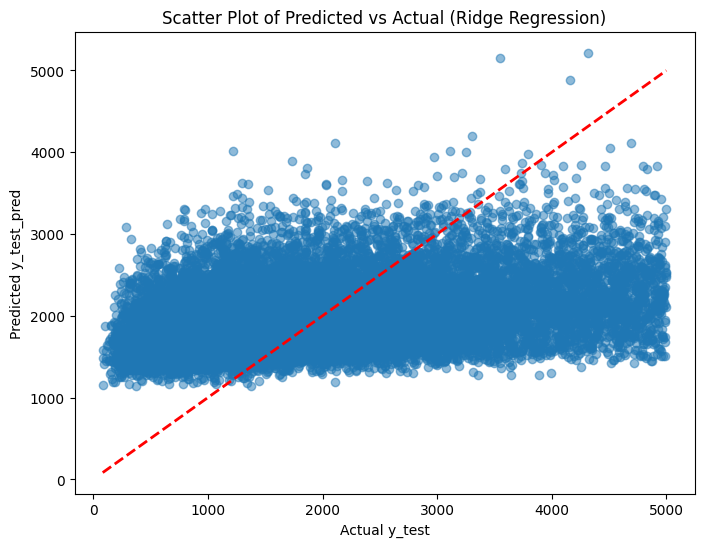

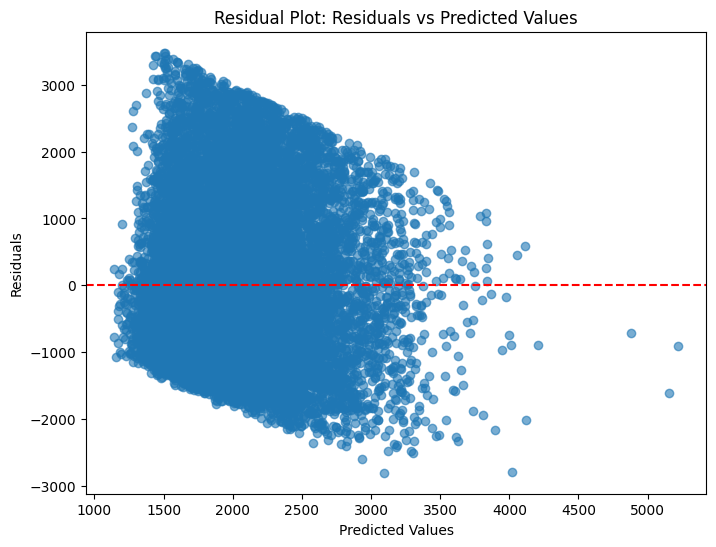



Experiment 2
Train RMSE: 1162.426799367824 -- Test RMSE: 1151.9471850666168


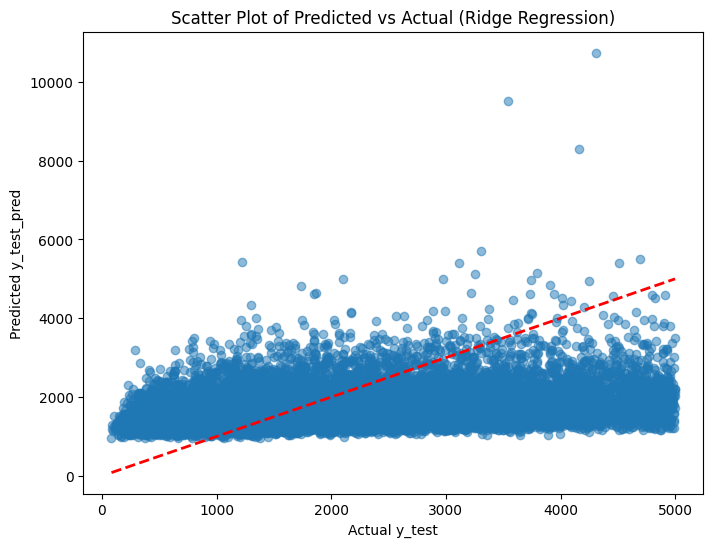

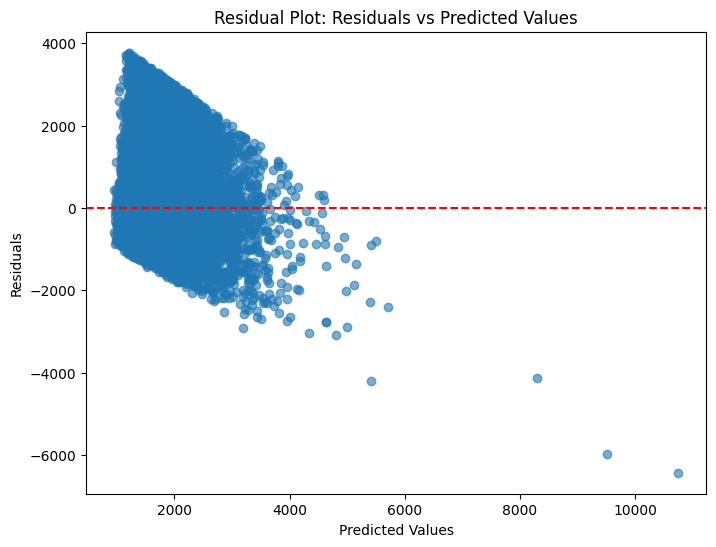

In [46]:
# Training a Linear Regression Model with l2 penalty

# Experiment 1: No transformation on target
print("Experiment 1")
model_ridge = Ridge(alpha=1)
model_ridge.fit(X_train, y_train)
#print(model_ridge.coef_)
y_train_pred = model_ridge.predict(X_train)
y_test_pred = model_ridge.predict(X_test)
#print(y_train_pred[0:10])
#print(y_test_pred[0:10])
get_error(y_test, y_test_pred, y_train, y_train_pred)

plot_actual_v_predictions(y_test, y_test_pred)
plot_predictions_v_residuals(y_test, y_test_pred)

# Experiment 2
# Retrain Linear Regression with Log Transform for target
# Since y/ target is higly right skewed, let's try transforming it on a log scale
print("\n\nExperiment 2")
model_ridge = Ridge(alpha=1)
model_ridge.fit(X_train, np.log1p(y_train))
#print(model_ridge.coef_)
y_train_pred = model_ridge.predict(X_train)
y_test_pred = model_ridge.predict(X_test)
y_train_pred = np.expm1(model_ridge.predict(X_train))
y_test_pred = np.expm1(model_ridge.predict(X_test))
#print(y_train_pred[0:10])
#print(y_test_pred[0:10])
get_error(y_test, y_test_pred, y_train, y_train_pred)

plot_actual_v_predictions(y_test, y_test_pred)
plot_predictions_v_residuals(y_test, y_test_pred)


In [ ]:
# Linear regression - Hyper parameter tuning

# Hyperparameter grid for Ridge
ridge_alpha_list =  [0, 0.0001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

for alpha in ridge_alpha_list:
    print("alpha: ", alpha)
    # Since y/ target is higly right skewed, let's try transforming it on a log scale
    model_ridge = Pipeline([
        ("StandardScaler", StandardScaler()),
        ("Ridge", Ridge(alpha=alpha))
    ])
    model_ridge.fit(X_train, y_train)
    #print(model_ridge.coef_)
    y_train_pred = model_ridge.predict(X_train)
    y_test_pred = model_ridge.predict(X_test)
    #print(y_train_pred[0:10])
    #print(y_test_pred[0:10])
    get_error(y_test, y_test_pred, y_train, y_train_pred)


alpha:  0
Train RMSE: 1108.4729075865616 -- Test RMSE: 1101.7712492391033
alpha:  0.0001
Train RMSE: 1108.4729075865616 -- Test RMSE: 1101.7712492502549
alpha:  0.01
Train RMSE: 1108.472907586569 -- Test RMSE: 1101.771250354247
alpha:  0.1
Train RMSE: 1108.4729075872892 -- Test RMSE: 1101.7712603910954
alpha:  1
Train RMSE: 1108.4729076593142 -- Test RMSE: 1101.7713608145546
alpha:  10
Train RMSE: 1108.4729148499164 -- Test RMSE: 1101.772370536008
alpha:  100
Train RMSE: 1108.4736222074303 -- Test RMSE: 1101.7830057931753
alpha:  1000
Train RMSE: 1108.5341342311588 -- Test RMSE: 1101.9339117621935
alpha:  10000
Train RMSE: 1110.6241452427382 -- Test RMSE: 1104.4728982179743


In [48]:
# Training a Linear Regression Model with l2 penalty - Best Parameters

#No transformation on target
model_ridge = Ridge(alpha=10)
model_ridge.fit(X_train, y_train)
#print(model_ridge.coef_)
y_train_pred = model_ridge.predict(X_train)
y_test_pred = model_ridge.predict(X_test)
#print(y_train_pred[0:10])
#print(y_test_pred[0:10])
errors = get_error(y_test, y_test_pred, y_train, y_train_pred)


Train RMSE: 1108.4730152558018 -- Test RMSE: 1101.773663683208


### Random Forest Regressor & Hyper-Param tuning

In [49]:
# Random Forest Regressor - Default Parameters
model_rf = Pipeline([
    ("RF", RandomForestRegressor(max_depth=11))
])
model_rf.fit(X_train, y_train)
#print(model_ridge.coef_)
y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)
#print(y_train_pred[0:10])
#print(y_test_pred[0:10])
get_error(y_test, y_test_pred, y_train, y_train_pred)


Train RMSE: 1058.3184254397604 -- Test RMSE: 1102.603369177773


(np.float64(1102.603369177773), np.float64(1058.3184254397604))

In [50]:
# Random Forest Hyperparam Tuning
param_dist = {
    "n_estimators": np.arange(10, 125, 25),
    "max_depth": list(np.arange(5, 16, 5)),
    #"min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1,  4, 16, 32, 64, 128],
    "max_features": ["sqrt", "log2", 0.3, 0.5],
    "bootstrap": [True]
}
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=50,               # increase for more thorough search
    scoring="neg_root_mean_squared_error",
    cv=4,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best params: {'n_estimators': np.int64(60), 'min_samples_leaf': 64, 'max_features': 0.5, 'max_depth': np.int64(10), 'bootstrap': True}
Best CV RMSE: 1107.813768968605


In [51]:
# Random Forest Regressor - Best Parameters
model_rf = Pipeline([
    ("RF", RandomForestRegressor(**search.best_params_))
])
model_rf.fit(X_train, y_train)
#print(model_ridge.coef_)
y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)
#print(y_train_pred[0:10])
#print(y_test_pred[0:10])
get_error(y_test, y_test_pred, y_train, y_train_pred)

Train RMSE: 1098.0594431957488 -- Test RMSE: 1099.8405465940682


(np.float64(1099.8405465940682), np.float64(1098.0594431957488))

In [52]:
# Feature Importance
feature_impo_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model_rf['RF'].feature_importances_
    })

print(feature_impo_df.sort_values('importance', ascending=False))


                       feature  importance
0                chronic_count    0.399534
1                 is_high_risk    0.165205
2  days_hospitalized_last_3yrs    0.095956
3                          age    0.083014
8                 smoker_Never    0.070865
4                          bmi    0.063432
6             visits_last_year    0.056884
5   hospitalizations_last_3yrs    0.046476
7                smoker_Former    0.018633


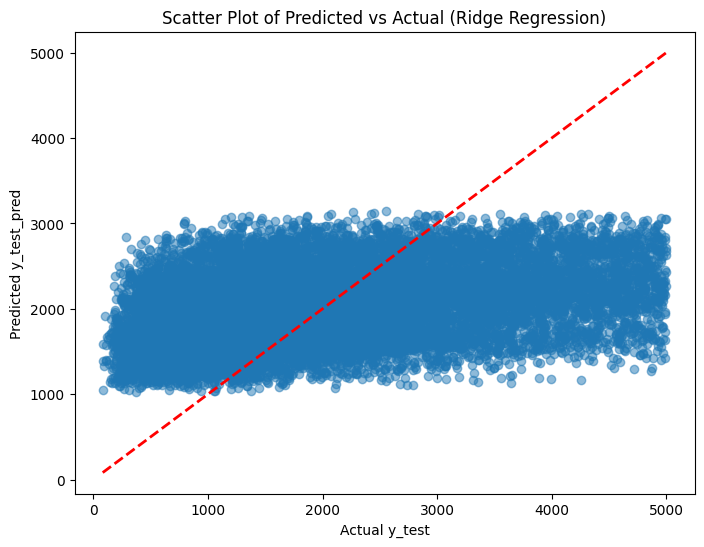

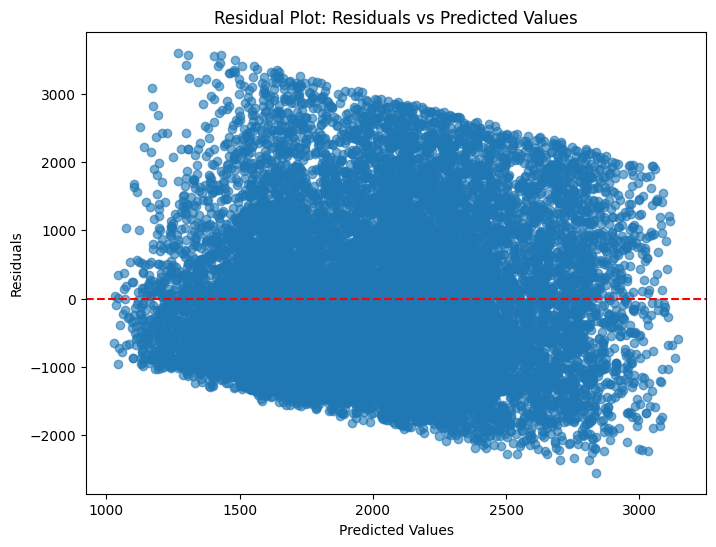

In [53]:
# Ploting Error Plots
plot_actual_v_predictions(y_test, y_test_pred)
plot_predictions_v_residuals(y_test, y_test_pred)


### Storing Models and Preprocessor


In [54]:
import joblib 
models_dir = "../data/models"
joblib.dump((preprocessor, model_ridge), f"{models_dir}/model.joblib")


['../data/models/model.joblib']

In [55]:
import joblib 
models_dir = "../data/models"
preprocessor, model = joblib.load(f"{models_dir}/model.joblib")

In [56]:

test_instance = pd.DataFrame({
          'chronic_count': 6, 
          'is_high_risk': 1, 
          'days_hospitalized_last_3yrs': 20,
          'age': 60,
          'smoker': 'Never',
          'bmi': 50, 
          'hospitalizations_last_3yrs': 2, 
          'visits_last_year': 5
}, index=[0])
print("\nOriginal data")
print(test_instance)
print("\nProcessed data")
print(preprocessor.transform(test_instance))
print("\nPrediction")
print(model.predict(preprocessor.transform(test_instance)))



Original data
   chronic_count  is_high_risk  days_hospitalized_last_3yrs  age smoker  bmi  \
0              6             1                           20   60  Never   50   

   hospitalizations_last_3yrs  visits_last_year  
0                           2                 5  

Processed data
[[ 7.07416948  1.44011095 17.44291467  0.83078634  4.61801982  7.22895075
   1.96039697  0.          1.        ]]

Prediction
[6956.46996766]
